In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit, least_squares, minimize
import matplotlib

matplotlib.rcParams['font.family'] = ['serif']
matplotlib.rcParams['font.size'] = 14

In [2]:
# Load the major plot
path = r"G:\Shared drives\L10237-TG-10nm\All Document\fig3_processing\data_ratio"

qt_2d_12_right = np.load(path + r"\12tg_right_2d_qt.npy")
qomega_2d_12_right = np.load(path + r"\12tg_right_2d_qomega.npy")
qarray_2d_12_right = np.load(path + r"\12tg_right_2d_qarray.npy") * np.pi * 2
phonon_2d_12_right = np.load(path + r"\12tg_right_2d_LA.npy")
phonon_2d_12_right_to = np.load(path + r"\12tg_right_2d_TO.npy")
time_right = np.load(path + r"\12nm_right_1d_t.npy")
omega_right = np.load(path + r'\12nm_right_1d_omega_v2.npy')

# Load the major plot
qt_2d_12_left = np.load(path + r"\12tg_left_2d_qt.npy")
qomega_2d_12_left = np.load(path + r"\12tg_left_2d_qomega.npy")
qarray_2d_12_left = np.load(path + r"\12tg_left_2d_qarray.npy") * np.pi * 2
phonon_2d_12_left = np.load(path + r"\12tg_left_2d_LA.npy")
phonon_2d_12_left_to = np.load(path + r"\12tg_left_2d_TO.npy")
time_left = np.load(path + r"\12nm_left_1d_t.npy")
omega_left = np.load(path + r'\12nm_left_1d_omega_v2.npy')

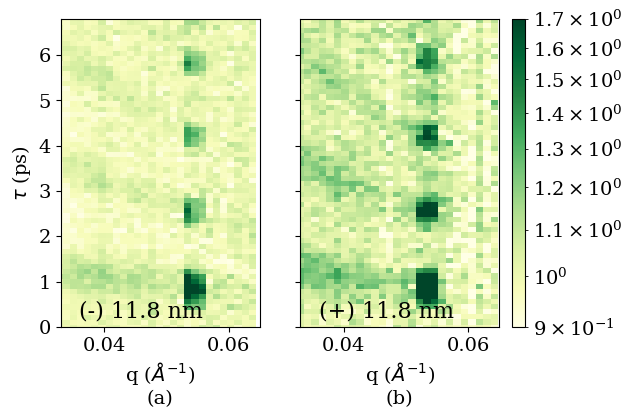

In [3]:
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figheight(4)
fig.set_figwidth(6.5)

ax1 = axes[0]
ax2 = axes[1]

xlim = [0.033, 0.065]
vmax = 1.7
vmin = 0.9
cmap = 'BuPu'
#cmap='cividis'
cmap = 'magma'
cmap = 'YlGn'
# --------------------------------------------------------------
im1 = ax1.imshow(qt_2d_12_left,
                 cmap=cmap,
                 aspect='auto',
                 norm=LogNorm(vmin=vmin, vmax=vmax),
                 #vmin=vmin, vmax=vmax,
                 origin='lower',
                 extent=[qarray_2d_12_left[0], qarray_2d_12_left[-1],
                         time_left[0] - 3.67192887, time_left[-1] - 3.67192887, ])
ax1.set_xlabel(r"q ($\AA^{-1}$)" + "\n(a)")
ax1.set_ylim([0, 6.8])
ax1.set_xlim(xlim)
ax1.set_ylabel(r"$\tau$ (ps)")

im2 = ax2.imshow(qt_2d_12_right,
                 cmap=cmap,
                 aspect='auto',
                 norm=LogNorm(vmin=vmin, vmax=vmax),
                 #vmin=vmin, vmax=vmax,
                 origin='lower',
                 extent=[qarray_2d_12_right[0], qarray_2d_12_right[-1],
                         time_right[0] - 3.67192887, time_right[-1] - 3.67192887, ])
ax2.set_xlabel(r"q ($\AA^{-1}$)" + "\n(b)")
ax2.set_ylim([0, 6.8])
ax2.set_yticklabels('')
ax2.set_xlim(xlim)
# -----------------------------------
ax1.text(x=0.036, y=0.2, s='(-) 11.8 nm', color='k', fontsize=16)
ax2.text(x=0.036, y=0.2, s='(+) 11.8 nm', color='k', fontsize=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.11, 0.02, 0.771])
cbar_img = fig.colorbar(im2, cax=cbar_ax, ticks=[10, 30, 50, 70])
cbar_img.ax.set_yticklabels(['10', '30', '50', '70'])

#plt.savefig("./fig3.png", dpi=300, bbox_inches='tight')
plt.show()

In [4]:
## Create mask for the left peak
start_time_left = 3.6
stop_time_left = 10.5

start_q_left = 0.034
stop_q_left = 0.05

"""
I would like to perform the following fitting

signal = (A exp(-q^2 sigma^2 / 2) / q^2 * exp(-t/taus) * (1-cos(q v t)))^2 + c
"""

## Create a mask for the 
mask = np.ones_like(qt_2d_12_left, dtype=bool)
mask[:, :] *= np.logical_and(time_left > start_time_left, time_left < stop_time_left)[:, np.newaxis]
mask[:, :] *= np.logical_and(qarray_2d_12_left > start_q_left, qarray_2d_12_left < stop_q_left)[np.newaxis:]

t = (time_left - 3.67192887)[:, np.newaxis]
q = qarray_2d_12_left[np.newaxis, :]

measure_left = np.copy(qt_2d_12_left)


def loss_fun_left(x):
    """
    x[0] = A
    x[1] = sigma^2 / 2   A^2
    x[2] = 1/taus        ps^-1 
    x[3] = v         3000 m/s = 3e3 * 10e10 / 1e12 = 30 A/ps
    x[4] = c     unitless
    """
    # Get the loss from the left peak
    val_left = x[0] * np.exp(- q ** 2 * x[1]) #* q
    val_left = val_left * np.exp(-t * x[2]) * (1 - np.cos(q * x[3] * t))
    val_left = np.square(val_left) + x[4]
    
    diff = (val_left - measure_left)[mask]
    val_left = np.sum(np.square(diff))

    return val_left

res_left = minimize(loss_fun_left,
                    x0=np.array([2.62241549e+00,  3.26725659e+02,  1.11638604e-01,  7.31707291e+01, -1.26376927e+00], ),
                    method=None,
                    bounds=((0.00001, 10000,),
                            (0.0, 400.,),
                            (0.00001, 4.),
                            (1, 100.),
                            (-10, 1000),
                            ),
                    )
print(res_left.success)
print(res_left.x)
print(np.sqrt(2 * res_left.x[1]))

True
[3.45491074e-01 3.26755055e+02 1.18738398e-01 7.27407158e+01
 9.79541416e-01]
25.56384378899671


In [5]:
# Get the fitted value
amplitude_left = res_left.x[0] * np.exp(- q ** 2 * res_left.x[1]) #* q
fit_left = amplitude_left * np.exp(-t * res_left.x[2]) * (1 - np.cos(q * res_left.x[3] * t))
fit_left = np.square(fit_left) + res_left.x[4]


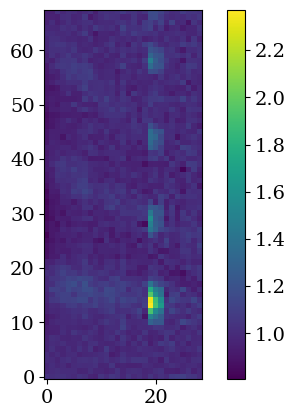

In [6]:
plt.imshow(qt_2d_12_left, origin='lower')
plt.colorbar()
plt.show()

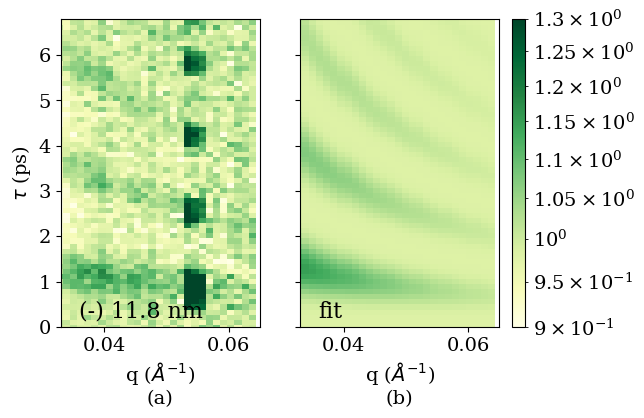

In [8]:
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figheight(4)
fig.set_figwidth(6.5)

ax1 = axes[0]
ax2 = axes[1]

xlim = [0.033, 0.065]
vmax = 1.3
vmin = 0.9
cmap = 'BuPu'
#cmap='cividis'
cmap = 'magma'
cmap = 'YlGn'
# --------------------------------------------------------------
im1 = ax1.imshow(qt_2d_12_left,
                 cmap=cmap,
                 aspect='auto',
                 norm=LogNorm(vmin=vmin, vmax=vmax),
                 #vmin=vmin, vmax=vmax,
                 origin='lower',
                 extent=[qarray_2d_12_left[0], qarray_2d_12_left[-1],
                         time_left[0] - 3.67192887, time_left[-1] - 3.67192887, ])
ax1.set_xlabel(r"q ($\AA^{-1}$)" + "\n(a)")
ax1.set_ylim([0, 6.8])
ax1.set_xlim(xlim)
ax1.set_ylabel(r"$\tau$ (ps)")

im2 = ax2.imshow(fit_left,
                 cmap=cmap,
                 aspect='auto',
                 norm=LogNorm(vmin=vmin, vmax=vmax),
                 #vmin=vmin, vmax=vmax,
                 origin='lower',
                 extent=[qarray_2d_12_left[0], qarray_2d_12_left[-1],
                         time_left[0] - 3.67192887, time_left[-1] - 3.67192887, ])
ax2.set_xlabel(r"q ($\AA^{-1}$)" + "\n(b)")
ax2.set_ylim([0, 6.8])
ax2.set_yticklabels('')
ax2.set_xlim(xlim)
# -----------------------------------
ax1.text(x=0.036, y=0.2, s='(-) 11.8 nm', color='k', fontsize=16)
ax2.text(x=0.036, y=0.2, s='fit', color='k', fontsize=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.11, 0.02, 0.771])
cbar_img = fig.colorbar(im2, cax=cbar_ax, ticks=[10, 30, 50, 70])
cbar_img.ax.set_yticklabels(['10', '30', '50', '70'])

plt.savefig("2d_fit.png", dpi=300, bbox_inches='tight')
plt.show()

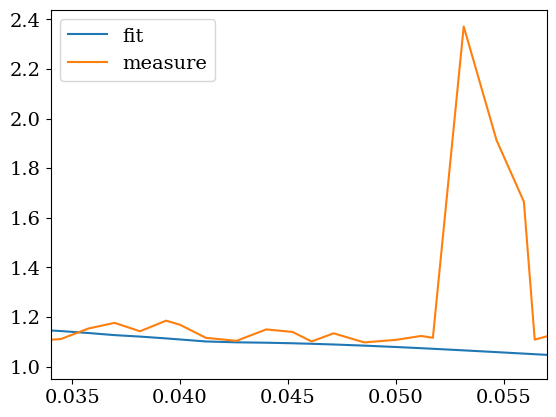

In [9]:
plt.plot(qarray_2d_12_left, np.max(fit_left, axis=0), label='fit')
plt.plot(qarray_2d_12_left, np.max(qt_2d_12_left, axis=0), label='measure')
plt.legend()
plt.xlim([0.034, 0.057])
plt.show()

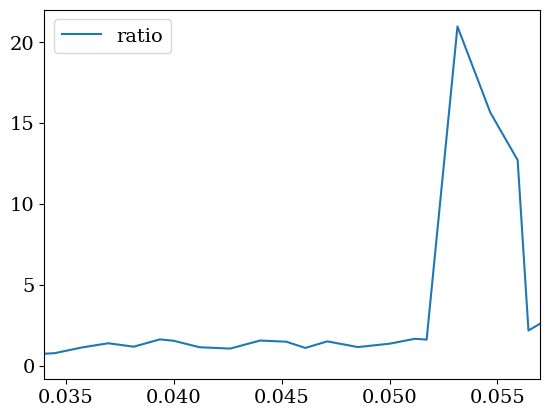

In [11]:
plt.plot(qarray_2d_12_left, (np.max(qt_2d_12_left, axis=0) - 1)/ (np.max(fit_left, axis=0) - 1), label='ratio')
plt.legend()
plt.xlim([0.034, 0.057])
plt.savefig("signal_ratio.png", dpi=300, bbox_inches='tight')
plt.show()